<a href="https://colab.research.google.com/github/olivieromassi/Hysteresis-Modelling-with-Neural-Networks/blob/main/HRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

import os

In [58]:
class HystereticRNNCell(tf.keras.layers.Layer):

    def __init__(self, alpha, beta, chi=None, **kwargs):
        if alpha.shape != beta.shape:
            raise ValueError(f'The dimensions of alpha and beta must be the same: alpha {alpha.shape} vs beta {beta.shape}')
        self.units = len(alpha)
        self.state_size = len(alpha)
        self.alpha = alpha
        self.beta = beta
        self.chi = chi
        if self.chi is None:
            self.chi = 10
        super(HystereticRNNCell, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units),
                                      initializer='ones',
                                      trainable=False,
                                      name='kernel')
        self.recurrent_kernel = self.add_weight(shape=(self.units,),
                                      initializer='ones',
                                      trainable=False,
                                      name='recurrent_kernel')
        self.built = True
    
    def call(self, inputs, states):
        prev_output = states[0]
        h = tf.keras.backend.dot(inputs, self.kernel)
        prev_output = prev_output * self.recurrent_kernel
        output = (1 - prev_output)/(1 + tf.math.exp((self.alpha - h)*self.chi)) + prev_output/(1 + tf.math.exp((self.beta - h)*self.chi))
        return output, [output]

In [40]:
# Defining some of the Network and Sequence parameters:
seq_len = 20
batch_size = 1

Defining the "forward" and "reverse" transformation values α and β according to the experiments conducted in the paper "*Hysteretic recurrent neural networks: a
tool for modeling hysteretic materials and
systems*"

In [61]:
beta_diff = [0.02, 0.17, 0.32, 0.47]
alpha_range = np.arange(0, 1.01, 0.01)


alpha = np.tile(alpha_range, len(beta_diff))
beta = []

for diff in beta_diff:
    beta.extend(np.round(alpha_range - diff, 2))

alpha = np.array(alpha)
beta = np.array(beta)

Model: "HRNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(1, 20, 1)]              0         
                                                                 
 rnn_8 (RNN)                 (1, 20, 404)              808       
                                                                 
 dense_5 (Dense)             (1, 20, 1)                404       
                                                                 
Total params: 1,212
Trainable params: 404
Non-trainable params: 808
_________________________________________________________________


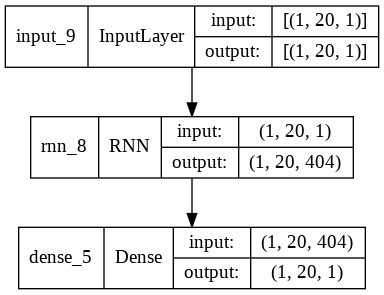

In [62]:
# Example: building a dRNN using the custom cell

cell = HystereticRNNCell(alpha=alpha, beta=beta)

inputs = tf.keras.layers.Input(shape=(seq_len, 1,), batch_size=batch_size)
layer = tf.keras.layers.RNN(cell, return_sequences=True)(inputs)
outputs = tf.keras.layers.Dense(1, activation='linear', use_bias=False, kernel_constraint=tf.keras.constraints.UnitNorm)(layer)


model = tf.keras.Model(inputs=inputs, outputs=outputs, name='HRNN')
model.summary()

tf.keras.utils.plot_model(model, show_shapes=True)